# Задача  
Реализовать модель, которая предсказывает дефолт клиента обратившегося в банк за кредитом

# 1. Загрузка библиотек и датасета

In [749]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.utils import shuffle 
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import os

import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

RANDOM_SEED = 42
!pip freeze > requirements.txt

# Загружаем датасеты
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)

# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv


# 2. Определение функций

In [750]:
def get_nan():
    ''' Создание датафрейма со всеми пропусками
    '''
    return(pd.DataFrame(df.isna().sum(), columns=['NaN']))

def numerical_check(col):
    ''' Построение гистограммы и вывод основных статистических данных цифровых признаков 
    '''
    plt.figure()
    sns.distplot(df[col], kde = False, rug=False)
    plt.title(col)
    plt.show()
    display(df[col].describe())
    

def categorical_check(col):
    ''' Вывод основных статистических данных категориальных признаков
    '''
    df[col].value_counts().plot.barh()
    plt.title(col)
    display(df[col].describe())
    

def outliers(col):
    ''' Поиск выбросов в данных. Выводятся границы и количество выбросов
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    drop = df[(df[col] <= l_side) | (df[col] >= r_side)]
    print('col: {}'.format(col),
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side),
          '\nout: {}'.format(len(drop)))
    
    
def get_corr(dataframe, col):
    ''' Построение тепловой карты коррелирующих признаков.
    '''
    df = dataframe
    plt.figure(figsize=(6, 5), dpi=300)
    sns.heatmap(df[col].corr(), cmap='RdYlGn',
                center=0, annot=True)
    plt.title('Correlation', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.show()
    
def roc_auc(model):
    model = model
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    

def model_metrics(model, name):
    model = model
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    acc = np.round(accuracy_score(y_test, preds), 3)
    prec = np.round(precision_score(y_test, preds), 3)
    rec = np.round(recall_score(y_test, preds), 3)
    f1 = np.round(f1_score(y_test, preds), 3)
    roc = np.round(roc_auc_score(y_test, probs), 3)
    return pd.DataFrame(columns=[name], index=['ROC AUC', 'Accuracy',
                                               'Precision', 'Recall',
                                               'F1'], data=[roc, acc,
                                                            prec, rec, f1])

# 3. Очистка и дополнение данных

In [751]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [752]:
print('Размер тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размер тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размер тренировочного датасета:  (73799, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1


Размер тестового датасета:  (36349, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Train
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0


In [753]:
get_nan()

,NaN
client_id,0
app_date,0
education,478
sex,0
age,0
car,0
car_type,0
decline_app_cnt,0
good_work,0
score_bki,0


Размер тренеровочного датасета - 73799  
Размер тестового датасета - 36349  
Всего данных - 110 148  
Всего признаков - 20  
Временных рядов - 1  
Числовые признаки - 4  
Бинарные признаки - 7  
Категориальные признаки - 8  
Всего пропусков - 478 

Описание признаков:
client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту  
Train - исскуственный признак обозначающий тренеровочный датасет  

## 3.1 client_id

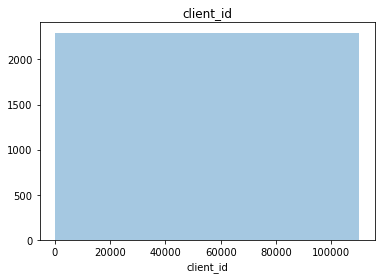

count    110148.000000
mean      55074.500000
std       31797.133063
min           1.000000
25%       27537.750000
50%       55074.500000
75%       82611.250000
max      110148.000000
Name: client_id, dtype: float64

In [754]:
numerical_check('client_id')

Линейно возрастающий признак, скорее всего банк присваивал каждому клиенту номер - признак не несет ценности

## 3.2 app_date

In [755]:
#Признак обозначающий дату, обработаем его
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
print(min(df.app_date))
print(max(df.app_date))

2014-01-01 00:00:00
2014-04-30 00:00:00


В датасете представлены данные с 1 января 2014 по апрель 2014 года, позже сгенерируем на основе данного признака новые признаки

## 3.3 education

count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object

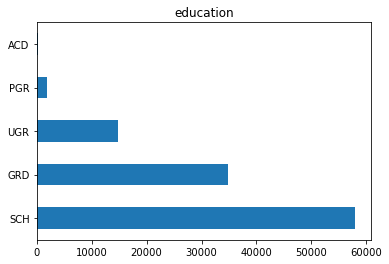

In [756]:
categorical_check('education')

Категориальный признак, имеются пропуски, заполним доминантной (SCH). В дальнейшем преобразуем в dummy

In [757]:
df.education.fillna('SCH', inplace=True)

## 3.4 sex

count     110148
unique         2
top            F
freq       61836
Name: sex, dtype: object

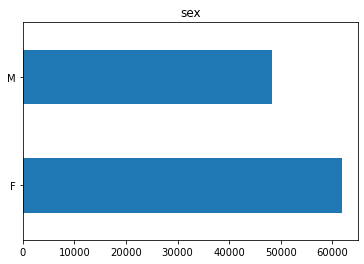

In [758]:
categorical_check('sex')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.4 age

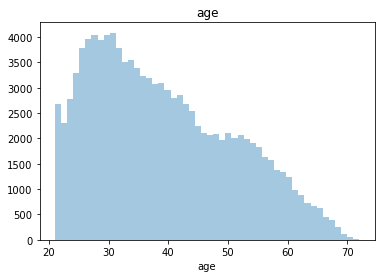

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

In [759]:
numerical_check('age')

Распределение нормальное, но смещенно, прологарифмируем признак

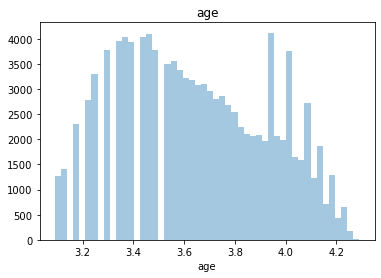

count    110148.000000
mean          3.654546
std           0.285054
min           3.091042
25%           3.433987
50%           3.637586
75%           3.891820
max           4.290459
Name: age, dtype: float64

In [760]:
df['age'] = np.log(df['age'] + 1)
numerical_check('age')

## 3.6 car

count     110148
unique         2
top            N
freq       74290
Name: car, dtype: object

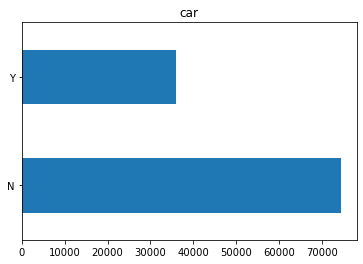

In [761]:
categorical_check('car')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.7 car_type

count     110148
unique         2
top            N
freq       89140
Name: car_type, dtype: object

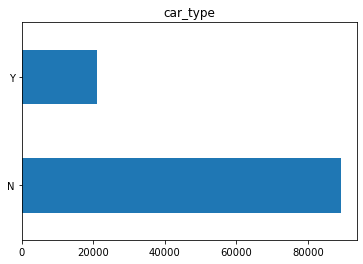

In [762]:
categorical_check('car_type')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.8 decline_app_cnt

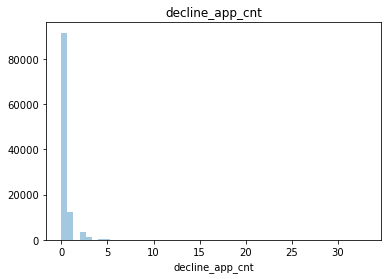

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [763]:
numerical_check('decline_app_cnt')

Есть явно выраженные выбросы, так как данный признак обозначает кол-во поданных отказаных заявок, то ограничемся максимальным возможным 5 разами, и тем самым исключим 238 данных, а также  прологарифмируем признак

In [764]:
print(len(df[(df['decline_app_cnt'] > 5) & (df['Train'] == 1)]))
print(len(df))

238
110148


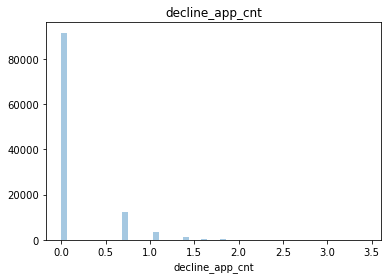

count    109910.000000
mean          0.147061
std           0.349676
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.433987
Name: decline_app_cnt, dtype: float64

In [765]:
# >5 - AUC=0.743 f1=0.347
# >6 - AUC=0.744 f1=0.345
df = df.drop(df[(df['decline_app_cnt'] > 5) & (df['Train'] == 1)].index)
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
numerical_check('decline_app_cnt')

## 3.9 good_work

count    109910.000000
mean          0.165626
std           0.371747
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: good_work, dtype: float64

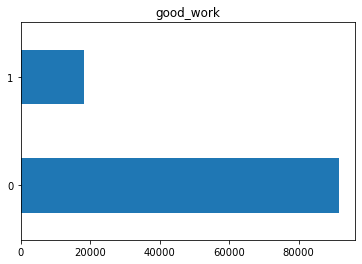

In [766]:
categorical_check('good_work')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.10 score_bki

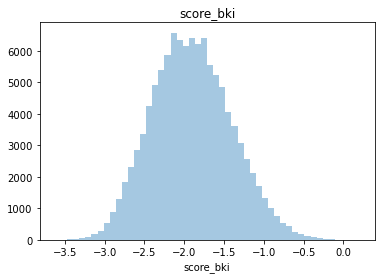

count    109910.000000
mean         -1.905613
std           0.498905
min          -3.624586
25%          -2.261301
50%          -1.921011
75%          -1.569249
max           0.199773
Name: score_bki, dtype: float64

In [767]:
numerical_check('score_bki')

Нормальное распределение

## 3.11 bki_request_cnt

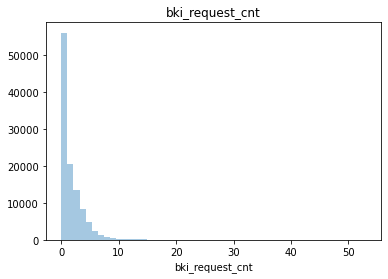

count    109910.000000
mean          1.999436
std           2.249490
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

In [768]:
numerical_check('bki_request_cnt')

In [769]:
outliers('bki_request_cnt')

col: bki_request_cnt 
left: -4.5 
right: 7.5 
out: 2591


Есть 2571 выброс, пробовал удалят, ухудшается f1 score. Поэтому оставляем и прологарифмируем

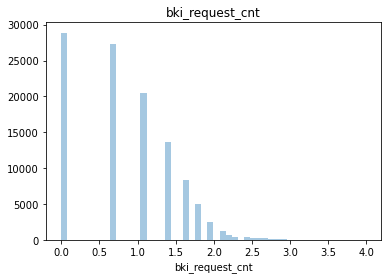

count    109910.000000
mean          0.877825
std           0.657755
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64

In [770]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
numerical_check('bki_request_cnt')

## 3.12 region_rating

count    109910.000000
mean         56.756164
std          13.065189
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

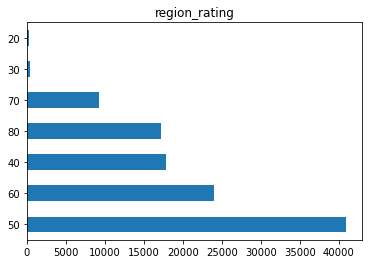

In [771]:
categorical_check('region_rating')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.13 home_address

count    109910.000000
mean          1.574779
std           0.527569
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: home_address, dtype: float64

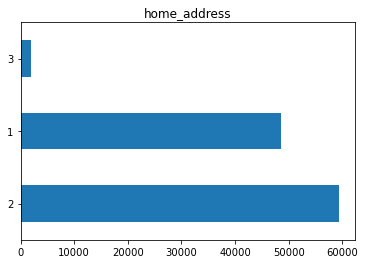

In [772]:
categorical_check('home_address')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.14 work_address

count    109910.000000
mean          2.497735
std           0.687657
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: work_address, dtype: float64

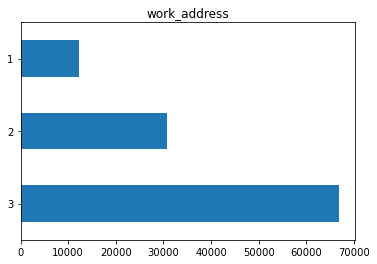

In [773]:
categorical_check('work_address')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.15 income

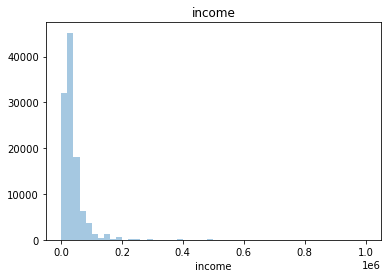

count     109910.000000
mean       41014.250851
std        45422.699314
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

In [774]:
numerical_check('income')

In [775]:
outliers('income')

col: income 
left: -22000.0 
right: 90000.0 
out: 7735


Есть 7728 выбросов, если все удалить, то получим снижение f1 score, пробовал выставлять границы, в конечном итоге f1 score ухудшался

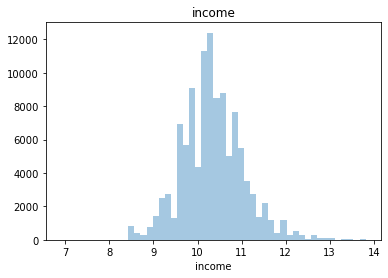

count    109910.000000
mean         10.345686
std           0.696779
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income, dtype: float64

In [776]:
#df = df.drop(df[(df['income'] > 300000) & (df['Train'] == 1)].index)
df['income'] = np.log(df['income'] + 1)
numerical_check('income')

## 3.16 sna

count    109910.000000
mean          1.730725
std           1.122162
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64

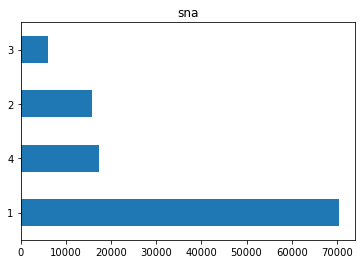

In [777]:
categorical_check('sna')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.17 first_time

count    109910.000000
mean          2.766272
std           1.010075
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64

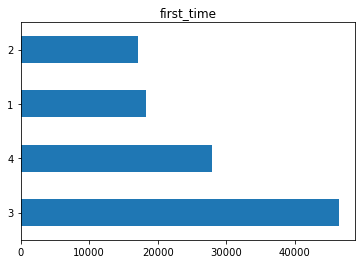

In [778]:
categorical_check('first_time')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.18 foreign_passport

count     109910
unique         2
top            N
freq       93519
Name: foreign_passport, dtype: object

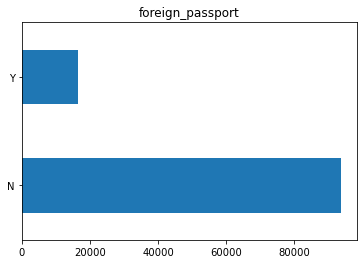

In [779]:
categorical_check('foreign_passport')

Пропусков нет, в дальнейшем преобразуем в dummy

## 3.19 default

count    73561.000000
mean         0.126331
std          0.332224
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

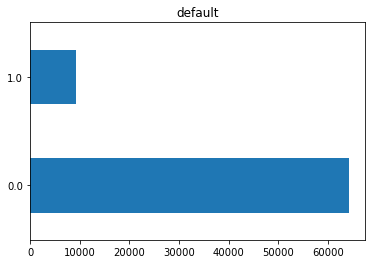

In [780]:
categorical_check('default')

Целевая переменная, при это имеется явная несбалансированная выборка

# 4 Новые признаки

## 4.1 month

count    109910.000000
mean          2.535383
std           1.087690
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: month, dtype: float64

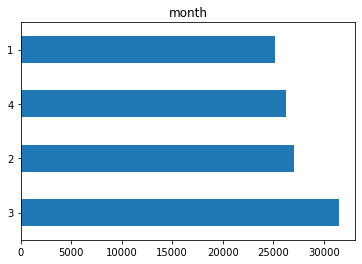

In [781]:
# добавим месяц подачи заявки
df['month'] = df.app_date.dt.month
categorical_check('month')

## 4.2 weekday_end

In [782]:
#Добавим тип дня подачи заявки будни/выходные
df['dayofweek'] = df.app_date.dt.dayofweek
df['weekday_end'] = df.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
df.drop('dayofweek', axis=1, inplace=True)

# 5 Анализ данных

In [783]:
# Распределим данные в списки
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekday_end']
# категориальные переменные
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'month']
# числовые переменные
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

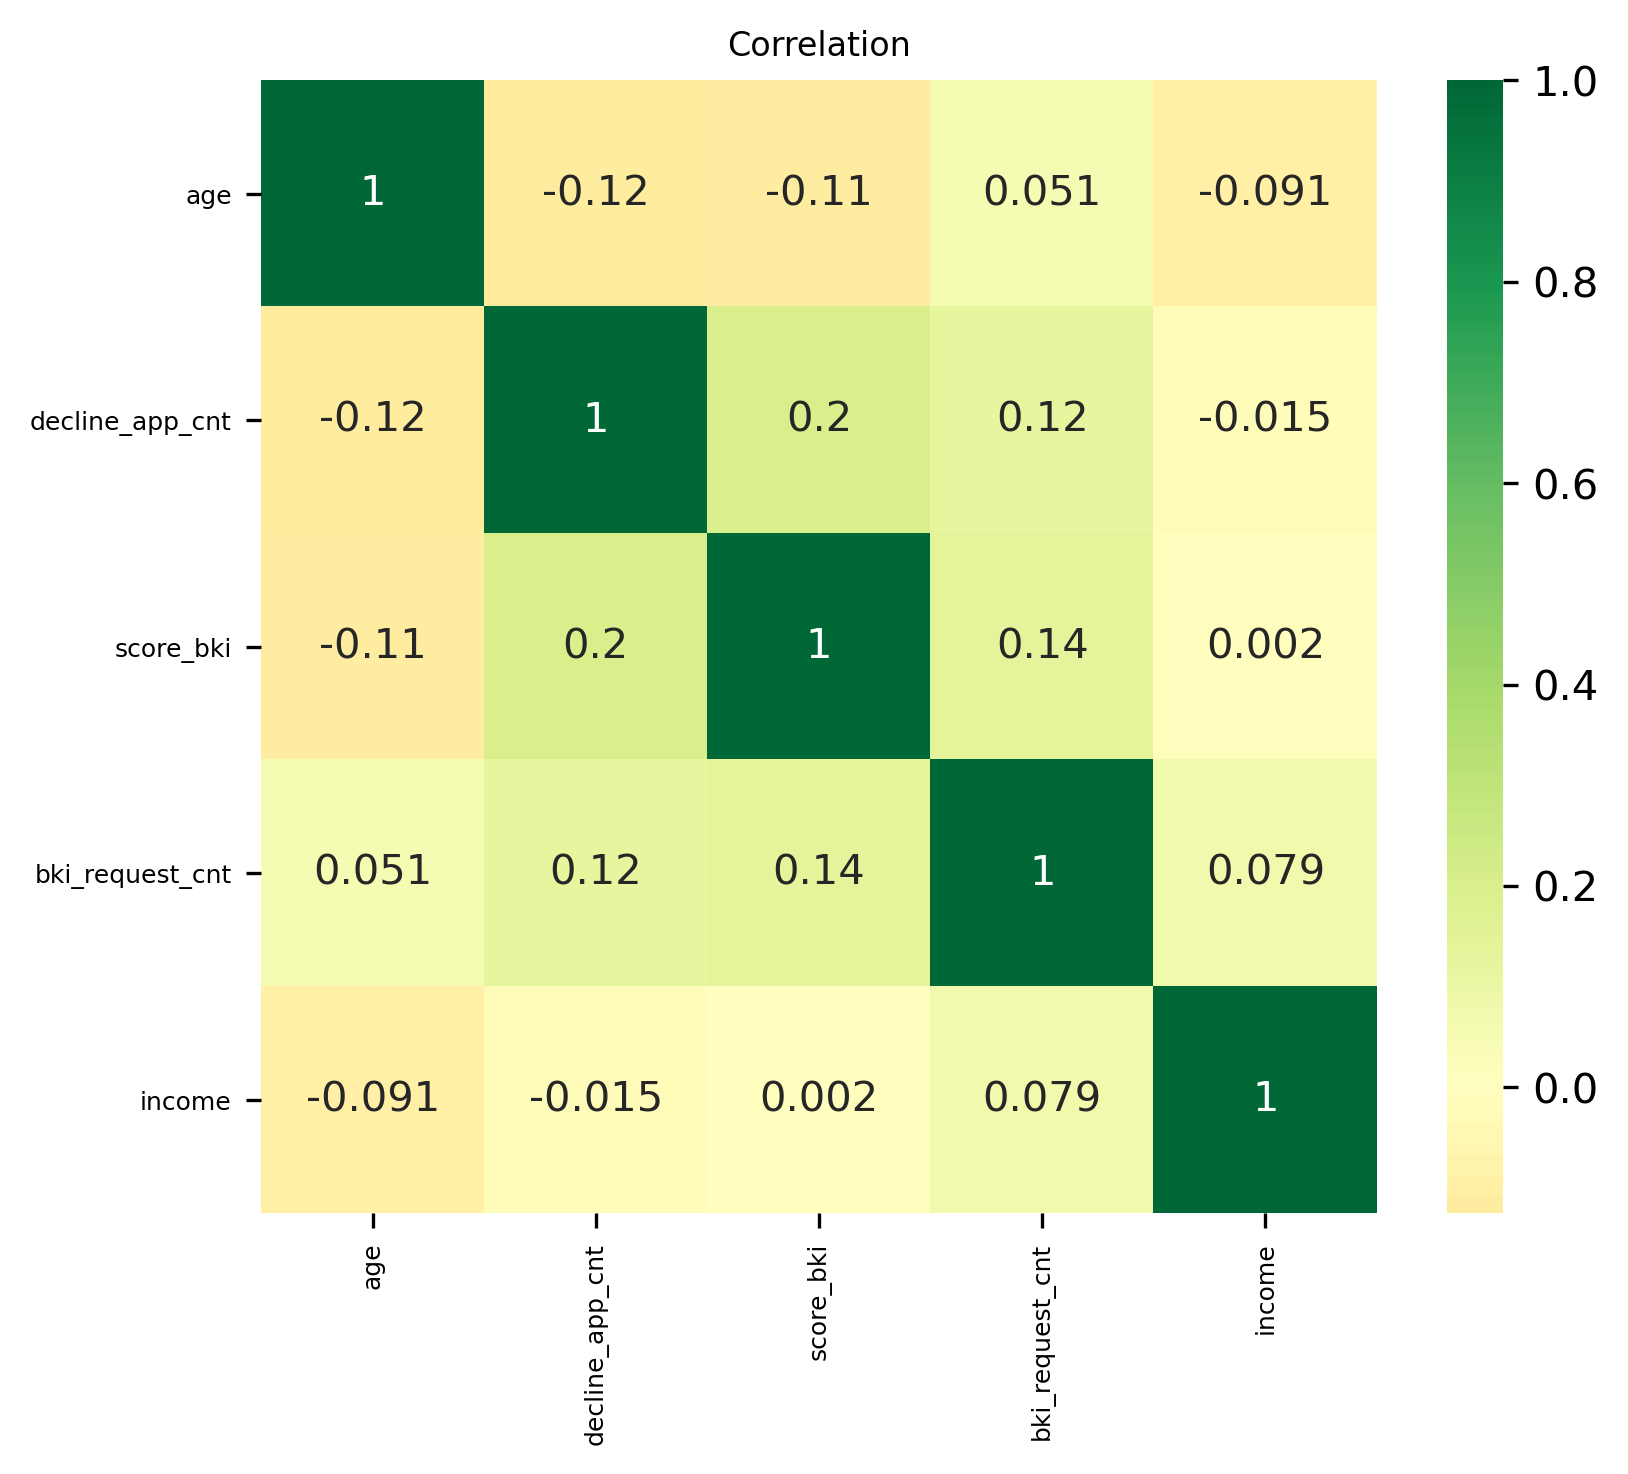

In [784]:
get_corr(df, num_cols)

Сильно коррелирующих признаков нет, поэтому оставим все числовые, посмотрим на значимые признаки для модели

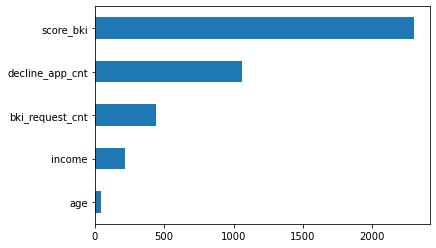

In [785]:
test_df = df[df['Train']==1]
imp_num = Series(f_classif(test_df[num_cols], test_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самый важный признак score_bki, что логично :)

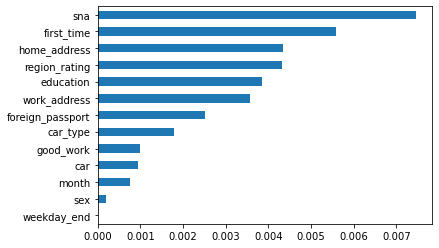

In [786]:
label_encoder = LabelEncoder()

for column in bin_cols:
    test_df[column] = label_encoder.fit_transform(test_df[column])

test_df.education = label_encoder.fit_transform(test_df.education)
imp_cat = Series(mutual_info_classif(test_df[bin_cols + cat_cols], test_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый важный признак sna которые показывает связь с банком, видимо внутри закодирован является ли клиент пользователям банка или нет

# 6 Подготовка данных для модели

In [787]:
# Обработаем бинарные признаки, а также сформируем dummy признаки и оставим только данные для модели
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
df.drop(['client_id', 'app_date'], axis=1, inplace=True)
df.head(2)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,weekday_end,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,month_1,month_2,month_3,month_4
0,1,4.143135,1,1,0.0,0,-2.008753,0.693147,9.798183,0,0.0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0
1,0,4.094345,0,0,0.0,0,-1.532276,1.386294,9.852247,0,0.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0


In [788]:
# разделяем датасет на тренировочный и тестовый
train_df = df.query('Train == 1').drop('Train', axis=1)
test_df = df.query('Train == 0').drop('Train', axis=1)

In [789]:
X = train_df.drop('default', axis=1)
y = train_df['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 7 Построение модели

## 7.1 обучение модели

In [790]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

## 7.2 метрики модели

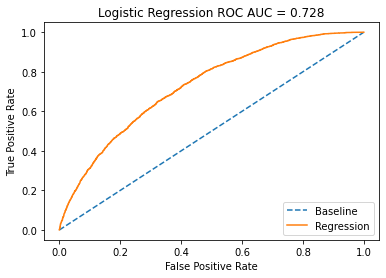

In [791]:
roc_auc(model_1)

In [792]:
model_1_metrics = model_metrics(model_1, 'model_1')
model_1_metrics

,model_1
ROC AUC,0.728
Accuracy,0.872
Precision,0.513
Recall,0.032
F1,0.061


In [793]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

61 58
1832 12762


Если смотреть метрику ROC AUC, то модель получилась относительно неплохая, но она плохо работает с несбаланисрованными данными, потому что если смотреть на матрицу ошибок, то видно как модель не угадала дефолтных клиентов. А вот метрика F1 прекрасно показывает качество нашей модели, т.е. модель - ужасная.

## 7.3 Подбор параметров модели

In [794]:
#Попробуем улучшить модель с помощью подбора параметров

model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False


Обучим модель с такими параметрами и посмотрим на метрики

In [795]:
model_2 = LogisticRegression(C=1.0,
                             class_weight='balanced',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=50,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l2',
                             random_state=RANDOM_SEED,
                             solver='newton-cg',
                             tol=0.001,
                             verbose=0,
                             warm_start=False)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

In [796]:
model_2_metrics = model_metrics(model_2, 'model_2')
models = model_1_metrics
models['model_2'] = model_2_metrics
models

,model_1,model_2
ROC AUC,0.728,0.728
Accuracy,0.872,0.669
Precision,0.513,0.227
Recall,0.032,0.653
F1,0.061,0.337


In [797]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

1236 4212
657 8608


После оптимизации модели, метрика F1 сильно возрасла, а значит модель стала работать лучше.

# 8 Балансируем данные и все заного :)

Проведя некоторое время за оптимизацией модели, а также эксперементов по удалению выбросов, я пришел к выводу, что самое лучшее это сбалансировать данные.  
Для этого обратимся к методам oversampling и undersampling.  
Для начала утроим данные с дефолтными клиентами, а потом удалим лишние данные без дефолтных клиентов. Для чистоты таких операций перемешает датасет.

In [798]:
train_df = shuffle(train_df) 
print(len(df))
print(len(df[df.default == 1]))
print(len(df[df.default == 0]))

109910
9293
64268


In [799]:
df_1 = train_df[train_df.default == 1]
df_0 = train_df[train_df.default == 0]
df_1_double = df_1.append(df_1)
df_1_triple = df_1_double.append(df_1)
df_balance = df_0[:len(df_1_triple)].append(df_1_triple)
df_balance = shuffle(df_balance)

print(len(df_balance))
print(len(df_balance[df_balance.default == 1]))
print(len(df_balance[df_balance.default == 0]))

55758
27879
27879


Почему именно так? К этом пришел путем нескольких итераций и сравнивая f1 полученных моделей

## 8.1 Обучаем модель на сбалансированных данных и смотрим метрики

In [800]:
X = df_balance.drop('default', axis=1)
y = df_balance['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [801]:
model_3 = LogisticRegression(random_state=RANDOM_SEED)
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
model_3_metrics = model_metrics(model_3, 'model_3')
models['model_3'] = model_3_metrics
models

,model_1,model_2,model_3
ROC AUC,0.728,0.728,0.739
Accuracy,0.872,0.669,0.675
Precision,0.513,0.227,0.678
Recall,0.032,0.653,0.673
F1,0.061,0.337,0.675


Как видим, f1 улучшилась в 2 раза, и даже ROC AUC слегка подросла. Оптимизируем параметры модели.

In [802]:
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [803]:
model_4 = LogisticRegression(C=1.0,
                             class_weight='balanced',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=50,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l2',
                             random_state=RANDOM_SEED,
                             solver='sag',
                             tol=0.001,
                             verbose=0,
                             warm_start=False)
model_4.fit(X_train, y_train)

model_4_metrics = model_metrics(model_4, 'model_4')
models['model_4'] = model_4_metrics
models

,model_1,model_2,model_3,model_4
ROC AUC,0.728,0.728,0.739,0.739
Accuracy,0.872,0.669,0.675,0.675
Precision,0.513,0.227,0.678,0.677
Recall,0.032,0.653,0.673,0.674
F1,0.061,0.337,0.675,0.676


После оптимизации f1 стал лучше

# 9 Кросс-валидация

In [804]:
#Проверим полученную модель на возможность переобучения

from sklearn.model_selection import cross_val_score
cross = cross_val_score(model_4, X_test, y_test, cv=10, scoring="f1")
delta = cross - np.mean(cross)
print('mean f1: ', np.round(np.mean(cross), 4))
print('mean delta', np.mean(delta))

mean f1:  0.6761
mean delta -2.2204460492503132e-17


Модель не подвержена переобучению

# 10 Submission

In [805]:
X_train = df_balance.drop('default', axis=1)
y_train = df_balance['default'].values
X_test = test_df.drop('default', axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [806]:
# проверяем
test_df.shape, df_balance.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 42), (55758, 42), (55758, 41), (55758,), (36349, 41))

In [807]:
model = LogisticRegression(C=1.0,
                             class_weight='none',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=50,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l2',
                             random_state=RANDOM_SEED,
                             solver='sag',
                             tol=0.001,
                             verbose=0,
                             warm_start=False)
model.fit(X_train, y_train)

LogisticRegression(class_weight='none', max_iter=50, random_state=42,
                   solver='sag', tol=0.001)

In [808]:
predict_submission = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = predict_submission
submit.to_csv('submission.csv', index=False)

In [809]:
submit

,client_id,default
0,74835,0.276898
1,17527,0.844084
2,75683,0.388496
3,26883,0.455946
4,28862,0.169780
...,...,...
36344,83775,0.845984
36345,106254,0.138391
36346,81852,0.860076
36347,1971,0.686649
